# load dataset

In [1]:
import pandas as pd

# melakukan load data
splits = {'train': 'data/train-00000-of-00001-daf190ce720b3dbb.parquet', 'test': 'data/test-00000-of-00001-fa9b3e8ade89a333.parquet'}
df = pd.read_parquet("hf://datasets/Deysi/spam-detection-dataset/" + splits["train"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
df.head()

,text,label
0,hey I am looking for Xray baggage datasets can...,not_spam
1,"""Get rich quick! Make millions in just days wi...",spam
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,spam
3,[Google AI Blog: Contributing Data to Deepfake...,not_spam
4,Trying to see if anyone already has timestamps...,not_spam


In [3]:
df["label"].value_counts() # distribusi label seimbang

,count
label,
spam,4125
not_spam,4050


In [4]:
# melakukan encoding label menjadi 0(not_spam), 1(spam)
map_label = {
    "not_spam": 0,
    "spam": 1
}
df["label"] = df["label"].map(map_label)

In [5]:
df.head()

,text,label
0,hey I am looking for Xray baggage datasets can...,0
1,"""Get rich quick! Make millions in just days wi...",1
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,1
3,[Google AI Blog: Contributing Data to Deepfake...,0
4,Trying to see if anyone already has timestamps...,0


In [6]:
df.duplicated().sum() # cek jumlah row yang duplikat

np.int64(133)

In [7]:
df = df.drop_duplicates() # menhapus row duplikat

In [8]:
df.shape

(8042, 2)

# Preprocess Data

In [9]:
from sklearn.model_selection import train_test_split

# melakukan split train(0.9) dan validasi(0.1)
# stratified untuk mempertahankan keseimbangan distribusi
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=31)

In [10]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [11]:
from transformers import AutoTokenizer

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [12]:
tokenizer.vocab_size # mengecek ukuran vocab dari tokenizer

28996

In [13]:
# Membuat kelas khusus dataset spam detection. digunakan training, validasi, dan testing
class SpamDetectionDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len=64):
    self.data = X.to_numpy()
    self.label = y.to_numpy()
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    text  = self.data[idx]
    label = self.label[idx]

    # tokenisasi text dengan outptu seukuran maksimum length
    # menambahkan token [CLS] pada awal dan [SEP] pada akhir kalimat
    # menambahkan token [PAD] agar ukuran output seragam seukuran maksimum length
    encoding = self.tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=self.max_len,
        return_tensors="pt"
    )

    return encoding["input_ids"].squeeze(0), encoding["attention_mask"].squeeze(0), torch.tensor(label, dtype=torch.float)

# Model

In [14]:
import torch
import torch.nn as nn
import numpy as np
import math
import torch.optim as optim

In [15]:
# definisi kelas positional encoding
class PositionalEncoding(nn.Module):
  def __init__(self, seq_len, embed_dim):
    super(PositionalEncoding, self).__init__()
    self.seq_len = seq_len
    self.embed_dim = embed_dim

    # initiasi positional matriks seukuran panjang sequence dan dimensi embedding
    pe_matriks = torch.zeros(seq_len, embed_dim)

    # mengisi value untuk matriks positional encoding
    position = torch.arange(0, self.seq_len, dtype=torch.float).unsqueeze(1) #
    div = 10000 ** (torch.arange(0, self.embed_dim, 2, dtype=torch.float)/self.embed_dim)

    pe_matriks[:, 0::2] = torch.sin(position/div)
    pe_matriks[:, 1::2] = torch.cos(position/div)
    self.register_buffer('pe_matriks', pe_matriks.unsqueeze(0)) # menggunakan register_buffer karena matriks positinal encoding bukan merupakan learnable parameter

  def forward(self, x):
    x = x + self.pe_matriks
    return x

In [16]:
# definisi kelas multi head attention(vanilla)
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_size = embed_dim // num_heads # ukuran setiap head disesaikan dengan ukuran embed dim dan jumlah head

    self.wq = nn.Linear(embed_dim, embed_dim)
    self.wk = nn.Linear(embed_dim, embed_dim)
    self.wv = nn.Linear(embed_dim, embed_dim)
    self.wo = nn.Linear(embed_dim, embed_dim)

  # mengubah bentuk untuk multihead attention (B, S, D) -> (B, H, S, HD)
  def split_input(self, x):
    batch_size, seq_len, embed_dim = x.shape
    return x.view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)

  # mengombinasikan output (B, H, S, HD) -> (B, S, D)
  def combine_output(self, x):
    batch_size, _, seq_len, _ = x.shape
    return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)

  def forward(self, q, k, v, mask=None):
    q_out = self.split_input(self.wq(q))
    k_out = self.split_input(self.wk(k))
    v_out = self.split_input(self.wv(v))

    attn = torch.matmul(q_out, k_out.transpose(-2, -1)) / math.sqrt(self.head_size)
    if mask is not None:
      mask = mask.unsqueeze(1).unsqueeze(3)
      attn = attn.masked_fill(mask == 0, -1e9) # memanfaatkan mask untuk memastikan token [PAD] tidak digunakan sebagai representasi teks
    prob = torch.softmax(attn, dim=-1)

    out = torch.matmul(prob, v_out)
    return self.wo(self.combine_output(out))

In [17]:
# definisi kelas multi head attention(MultiQueryAttention)
class MultiQueryAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super(MultiQueryAttention, self).__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_size = embed_dim // num_heads # ukuran setiap head disesaikan dengan ukuran embed dim dan jumlah head

    self.wq = nn.Linear(embed_dim, embed_dim)
    self.wk = nn.Linear(embed_dim, self.head_size) # ukuran disesuaikan karena shared untuk setiap head
    self.wv = nn.Linear(embed_dim, self.head_size) # ukuran disesuaikan karena shared untuk setiap head
    self.wo = nn.Linear(embed_dim, embed_dim)

   # mengubah bentuk untuk multihead attention (B, S, D) -> (B, H, S, HD)
  def split_input(self, x):
    batch_size, seq_len, embed_dim = x.shape
    return x.view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)

   # mengombinasikan output (B, H, S, HD) -> (B, S, D)
  def combine_output(self, x):
    batch_size, _, seq_len, _ = x.shape
    return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)

  def forward(self, q, k, v, mask=None):
    q_out = self.split_input(self.wq(q))
    k_out = self.wk(k).unsqueeze(1) # mengubak bentuk menjadi (B, 1, S, HD)
    v_out = self.wv(v).unsqueeze(1) # mengubak bentuk menjadi (B, 1, S, HD)

    attn = torch.matmul(q_out, k_out.transpose(-2, -1)) / math.sqrt(self.head_size)
    if mask is not None:
      mask = mask.unsqueeze(1).unsqueeze(3)
      attn = attn.masked_fill(mask == 0, -1e9) # memanfaatkan mask untuk memastikan token [PAD] tidak digunakan sebagai representasi teks
    prob = torch.softmax(attn, dim=-1)

    out = torch.matmul(prob, v_out)
    return self.wo(self.combine_output(out))

In [18]:
# definisi layer encoder
class EncoderLayer(nn.Module):
  def __init__(self, embed_dim, ffn_dim, num_heads, dropout_rate, attn = MultiHeadAttention):
    super(EncoderLayer, self).__init__()
    self.multi_head_attention = attn(embed_dim, num_heads)
    self.ffn = nn.Sequential(
        nn.Linear(embed_dim, ffn_dim),
        nn.ReLU(),
        nn.Linear(ffn_dim, embed_dim)
    )
    self.norm1 = nn.LayerNorm(embed_dim)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.dropout1 = nn.Dropout(dropout_rate)
    self.dropout2 = nn.Dropout(dropout_rate)

  def forward(self, x, mask=None):
    x = self.multi_head_attention(x, x, x, mask) # q, k, v adalah x karena self attention
    x = self.norm1(x + self.dropout1(x))
    x = self.ffn(x)
    x = self.norm2(x + self.dropout2(x))
    return x

In [19]:
# definisi transformer based classifier
class TransformerClassifier(nn.Module):
  def __init__(self, vocab_size, seq_len, embed_dim, num_heads, ffn_dim, num_layers, dropout_rate, attn = MultiHeadAttention):
    super(TransformerClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.positional_encoding = PositionalEncoding(seq_len, embed_dim)
    self.dropout = nn.Dropout(dropout_rate)
    self.layers = nn.ModuleList([EncoderLayer(embed_dim, ffn_dim, num_heads, dropout_rate, attn) for _ in range(num_layers)])
    self.classifier = nn.Sequential(
        nn.Linear(embed_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

  def forward(self, x, mask=None):
    x = self.embedding(x)
    x = self.positional_encoding(x)
    x = self.dropout(x)
    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0, :]  # menggunakan [CLS] token sebagai representasi keseluruhan teks untuk klasifikasi
    x = self.classifier(x)
    return x

# training

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
epoch = 10

In [28]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train(model, trainloader, valloader, criterion, optimizer, device):
  print('Start Training')
  train_losses = []
  val_losses = []
  model.train()
  for e in range(epoch):
    with tqdm(enumerate(trainloader), unit="batch", total = len(trainloader)) as tepoch:
      running_loss = 0.0
      for i, data in tepoch:
        tepoch.set_description(f"Epoch {e + 1}")

        # load batch data
        texts, masks, labels = data
        texts = texts.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        # zero gradient
        optimizer.zero_grad()

        # calculate loss + backward
        outputs = model(texts, masks)
        loss = criterion(outputs.squeeze(1), labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        avg_loss = running_loss/(i+1)
        tepoch.set_postfix(loss=loss.item(), avg_loss = avg_loss)

      # store train loss
      avg_train_loss = running_loss / len(trainloader)
      train_losses.append(avg_train_loss)

      # validation
      val_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
        for texts, masks, labels in valloader:
          texts, masks, labels = texts.to(device), masks.to(device), labels.to(device)

          # calculate loss
          outputs = model(texts, masks)
          loss = criterion(outputs.squeeze(1), labels)
          val_loss += loss.item()

          # get prediction
          preds = torch.sigmoid(outputs.squeeze(1))
          preds = (preds >= 0.5).long()
          labels = labels.long()

          # calculate statistics
          total += labels.size(0)
          correct += (preds == labels).sum().item()

      # store val losses
      avg_val_loss = val_loss / len(valloader)
      val_losses.append(avg_val_loss)

      print(f"Epoch [{e+1}/{epoch}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

  print('Finished Training')
  return train_losses, val_losses

def plot_loss(train_losses, val_losses):
  plt.figure(figsize=(10, 5))
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

## Model 1

In [25]:
# Hyperparameter
max_seq_len = 64
embed_dim = 128
num_heads = 4
ffn_dim = 256
num_layers = 2
dropout_rate = 0.1

batch_size = 64
learning_rate = 1e-3

attn = MultiHeadAttention

# Prepare Dataloader
trainset = SpamDetectionDataset(X_train, y_train, tokenizer, max_seq_len)
valset = SpamDetectionDataset(X_test, y_test, tokenizer, max_seq_len)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Prepare Model
model1 = TransformerClassifier(tokenizer.vocab_size, max_seq_len, embed_dim, num_heads, ffn_dim, num_layers, dropout_rate, attn)
model1.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model1.parameters(), lr=learning_rate)

In [26]:
train_losses, val_losses = train(model1, trainloader, valloader, criterion, optimizer, device)

Start Training


Epoch 1: 100%|██████████| 114/114 [00:07<00:00, 14.91batch/s, avg_loss=0.167, loss=0.00486]


Epoch [1/10], Train Loss: 0.1672, Val Loss: 0.0651, Accuracy: 98.26%


Epoch 2: 100%|██████████| 114/114 [00:06<00:00, 16.55batch/s, avg_loss=0.0329, loss=0.00117]


Epoch [2/10], Train Loss: 0.0329, Val Loss: 0.0303, Accuracy: 99.25%


Epoch 3: 100%|██████████| 114/114 [00:10<00:00, 10.48batch/s, avg_loss=0.0215, loss=0.000624]


Epoch [3/10], Train Loss: 0.0215, Val Loss: 0.0246, Accuracy: 99.50%


Epoch 4: 100%|██████████| 114/114 [00:09<00:00, 11.46batch/s, avg_loss=0.0217, loss=0.00274]


Epoch [4/10], Train Loss: 0.0217, Val Loss: 0.0115, Accuracy: 99.75%


Epoch 5: 100%|██████████| 114/114 [00:05<00:00, 20.03batch/s, avg_loss=0.0138, loss=0.00018]


Epoch [5/10], Train Loss: 0.0138, Val Loss: 0.0021, Accuracy: 99.88%


Epoch 6: 100%|██████████| 114/114 [00:05<00:00, 19.61batch/s, avg_loss=0.0169, loss=0.145]


Epoch [6/10], Train Loss: 0.0169, Val Loss: 0.0227, Accuracy: 98.76%


Epoch 7: 100%|██████████| 114/114 [00:07<00:00, 15.31batch/s, avg_loss=0.0627, loss=0.00157]


Epoch [7/10], Train Loss: 0.0627, Val Loss: 0.0591, Accuracy: 99.13%


Epoch 8: 100%|██████████| 114/114 [00:07<00:00, 14.74batch/s, avg_loss=0.159, loss=0.00442]


Epoch [8/10], Train Loss: 0.1593, Val Loss: 0.0527, Accuracy: 98.76%


Epoch 9: 100%|██████████| 114/114 [00:07<00:00, 15.19batch/s, avg_loss=0.0338, loss=0.00269]


Epoch [9/10], Train Loss: 0.0338, Val Loss: 0.0152, Accuracy: 99.50%


Epoch 10: 100%|██████████| 114/114 [00:05<00:00, 19.82batch/s, avg_loss=0.0121, loss=0.00103]


Epoch [10/10], Train Loss: 0.0121, Val Loss: 0.0161, Accuracy: 99.63%
Finished Training


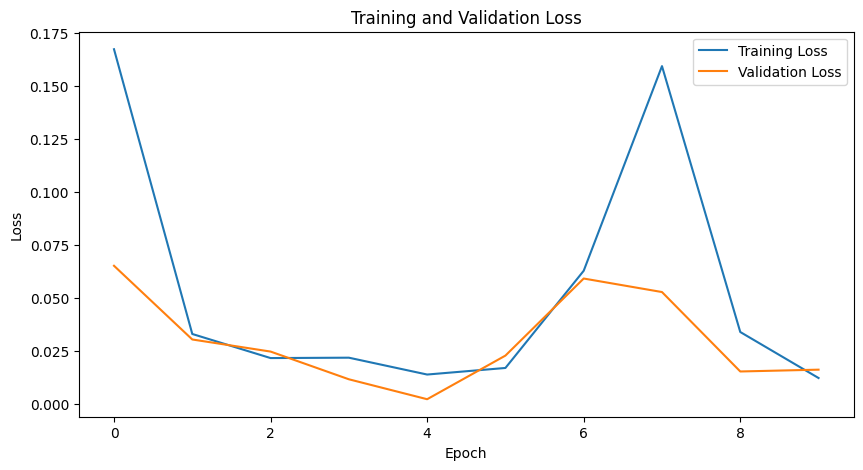

In [27]:
plot_loss(train_losses, val_losses)

## Model 2

In [56]:
# Hyperparameter
max_seq_len = 64
embed_dim = 64
num_heads = 2
ffn_dim = 128
num_layers = 1
dropout_rate = 0.1

batch_size = 64
learning_rate = 1e-3

attn = MultiHeadAttention

# Prepare Dataloader
trainset = SpamDetectionDataset(X_train, y_train, tokenizer, max_seq_len)
valset = SpamDetectionDataset(X_test, y_test, tokenizer, max_seq_len)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Prepare Model
model2 = TransformerClassifier(tokenizer.vocab_size, max_seq_len, embed_dim, num_heads, ffn_dim, num_layers, dropout_rate, attn)
model2.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model2.parameters(), lr=learning_rate)

In [57]:
train_losses, val_losses = train(model2, trainloader, valloader, criterion, optimizer, device)

Start Training


Epoch 1: 100%|██████████| 114/114 [00:10<00:00, 10.60batch/s, avg_loss=0.21, loss=0.00881]


Epoch [1/10], Train Loss: 0.2097, Val Loss: 0.0588, Accuracy: 97.76%


Epoch 2: 100%|██████████| 114/114 [00:04<00:00, 24.47batch/s, avg_loss=0.0397, loss=0.0271]


Epoch [2/10], Train Loss: 0.0397, Val Loss: 0.0284, Accuracy: 99.01%


Epoch 3: 100%|██████████| 114/114 [00:07<00:00, 15.15batch/s, avg_loss=0.018, loss=0.00594]


Epoch [3/10], Train Loss: 0.0180, Val Loss: 0.0227, Accuracy: 99.25%


Epoch 4: 100%|██████████| 114/114 [00:04<00:00, 23.35batch/s, avg_loss=0.0183, loss=0.00111]


Epoch [4/10], Train Loss: 0.0183, Val Loss: 0.0102, Accuracy: 99.50%


Epoch 5: 100%|██████████| 114/114 [00:05<00:00, 21.22batch/s, avg_loss=0.0119, loss=0.000907]


Epoch [5/10], Train Loss: 0.0119, Val Loss: 0.0361, Accuracy: 98.63%


Epoch 6: 100%|██████████| 114/114 [00:07<00:00, 16.21batch/s, avg_loss=0.0227, loss=0.239]


Epoch [6/10], Train Loss: 0.0227, Val Loss: 0.0150, Accuracy: 99.63%


Epoch 7: 100%|██████████| 114/114 [00:10<00:00, 11.04batch/s, avg_loss=0.0236, loss=0.0314]


Epoch [7/10], Train Loss: 0.0236, Val Loss: 0.0268, Accuracy: 99.50%


Epoch 8: 100%|██████████| 114/114 [00:08<00:00, 13.82batch/s, avg_loss=0.0123, loss=0.00113]


Epoch [8/10], Train Loss: 0.0123, Val Loss: 0.0110, Accuracy: 99.38%


Epoch 9: 100%|██████████| 114/114 [00:07<00:00, 15.50batch/s, avg_loss=0.00855, loss=0.00059]


Epoch [9/10], Train Loss: 0.0085, Val Loss: 0.0159, Accuracy: 99.50%


Epoch 10: 100%|██████████| 114/114 [00:06<00:00, 16.32batch/s, avg_loss=0.00617, loss=0.000347]


Epoch [10/10], Train Loss: 0.0062, Val Loss: 0.0105, Accuracy: 99.88%
Finished Training


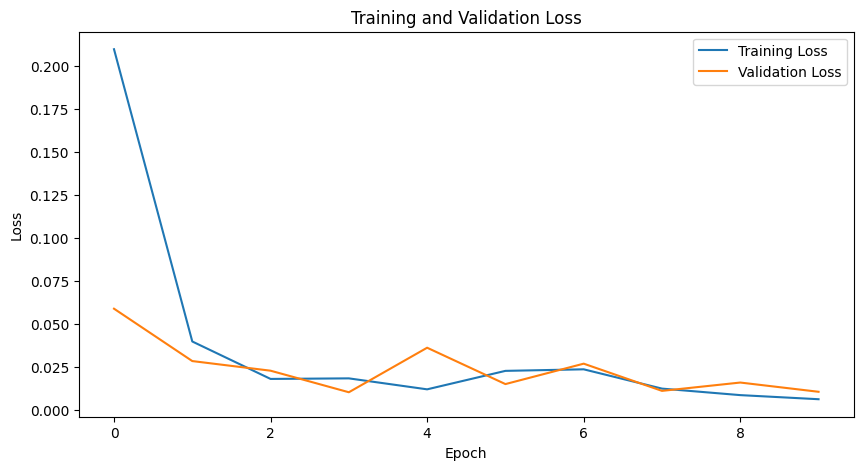

In [58]:
plot_loss(train_losses, val_losses)

## Model 3

In [59]:
# Hyperparameter
max_seq_len = 64
embed_dim = 128
num_heads = 4
ffn_dim = 256
num_layers = 2
dropout_rate = 0.1

batch_size = 64
learning_rate = 1e-3

attn = MultiQueryAttention

# Prepare Dataloader
trainset = SpamDetectionDataset(X_train, y_train, tokenizer, max_seq_len)
valset = SpamDetectionDataset(X_test, y_test, tokenizer, max_seq_len)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Prepare Model
model3 = TransformerClassifier(tokenizer.vocab_size, max_seq_len, embed_dim, num_heads, ffn_dim, num_layers, dropout_rate, attn)
model3.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model3.parameters(), lr=learning_rate)

In [60]:
train_losses, val_losses = train(model3, trainloader, valloader, criterion, optimizer, device)

Start Training


Epoch 1: 100%|██████████| 114/114 [00:10<00:00, 10.85batch/s, avg_loss=0.132, loss=0.00257]


Epoch [1/10], Train Loss: 0.1320, Val Loss: 0.0484, Accuracy: 98.39%


Epoch 2: 100%|██████████| 114/114 [00:05<00:00, 19.75batch/s, avg_loss=0.0222, loss=0.000654]


Epoch [2/10], Train Loss: 0.0222, Val Loss: 0.0264, Accuracy: 99.38%


Epoch 3: 100%|██████████| 114/114 [00:05<00:00, 20.18batch/s, avg_loss=0.02, loss=0.00174]


Epoch [3/10], Train Loss: 0.0200, Val Loss: 0.0298, Accuracy: 99.13%


Epoch 4: 100%|██████████| 114/114 [00:09<00:00, 11.58batch/s, avg_loss=0.0198, loss=0.000681]


Epoch [4/10], Train Loss: 0.0198, Val Loss: 0.0275, Accuracy: 99.13%


Epoch 5: 100%|██████████| 114/114 [00:08<00:00, 13.61batch/s, avg_loss=0.0136, loss=0.000447]


Epoch [5/10], Train Loss: 0.0136, Val Loss: 0.0127, Accuracy: 99.75%


Epoch 6: 100%|██████████| 114/114 [00:12<00:00,  8.84batch/s, avg_loss=0.0108, loss=0.0175]


Epoch [6/10], Train Loss: 0.0108, Val Loss: 0.0225, Accuracy: 99.13%


Epoch 7: 100%|██████████| 114/114 [00:08<00:00, 13.54batch/s, avg_loss=0.00753, loss=0.00038]


Epoch [7/10], Train Loss: 0.0075, Val Loss: 0.0212, Accuracy: 99.25%


Epoch 8: 100%|██████████| 114/114 [00:07<00:00, 15.51batch/s, avg_loss=0.00533, loss=0.000226]


Epoch [8/10], Train Loss: 0.0053, Val Loss: 0.0183, Accuracy: 99.75%


Epoch 9: 100%|██████████| 114/114 [00:05<00:00, 19.62batch/s, avg_loss=0.02, loss=0.00212]


Epoch [9/10], Train Loss: 0.0200, Val Loss: 0.0240, Accuracy: 99.25%


Epoch 10: 100%|██████████| 114/114 [00:05<00:00, 22.25batch/s, avg_loss=0.00767, loss=0.000399]


Epoch [10/10], Train Loss: 0.0077, Val Loss: 0.0145, Accuracy: 99.63%
Finished Training


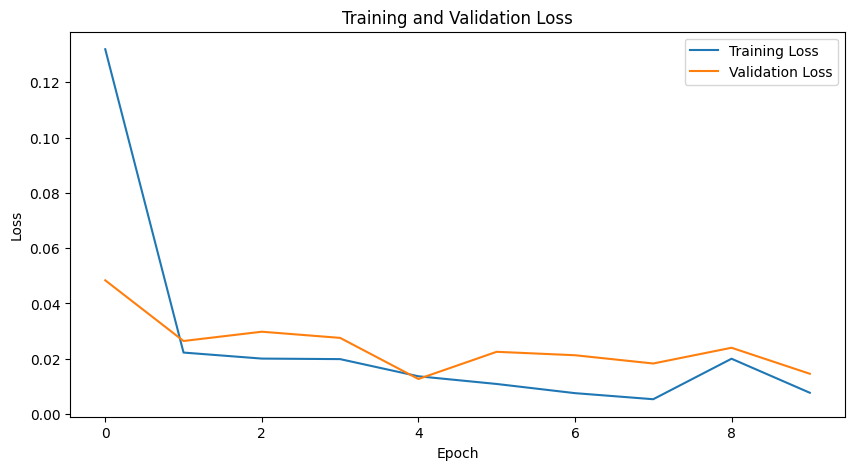

In [61]:
plot_loss(train_losses, val_losses)

## Model 4

In [62]:
# Hyperparameter
max_seq_len = 64
embed_dim = 64
num_heads = 2
ffn_dim = 128
num_layers = 1
dropout_rate = 0.1

batch_size = 64
learning_rate = 1e-3

attn = MultiQueryAttention

# Prepare Dataloader
trainset = SpamDetectionDataset(X_train, y_train, tokenizer, max_seq_len)
valset = SpamDetectionDataset(X_test, y_test, tokenizer, max_seq_len)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Prepare Model
model4 = TransformerClassifier(tokenizer.vocab_size, max_seq_len, embed_dim, num_heads, ffn_dim, num_layers, dropout_rate, attn)
model4.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model4.parameters(), lr=learning_rate)

In [63]:
train_losses, val_losses = train(model4, trainloader, valloader, criterion, optimizer, device)

Start Training


Epoch 1: 100%|██████████| 114/114 [00:07<00:00, 15.00batch/s, avg_loss=0.153, loss=0.0191]


Epoch [1/10], Train Loss: 0.1533, Val Loss: 0.0710, Accuracy: 97.76%


Epoch 2: 100%|██████████| 114/114 [00:04<00:00, 23.09batch/s, avg_loss=0.0406, loss=0.00205]


Epoch [2/10], Train Loss: 0.0406, Val Loss: 0.0280, Accuracy: 99.01%


Epoch 3: 100%|██████████| 114/114 [00:05<00:00, 21.93batch/s, avg_loss=0.0255, loss=0.00219]


Epoch [3/10], Train Loss: 0.0255, Val Loss: 0.0234, Accuracy: 99.25%


Epoch 4: 100%|██████████| 114/114 [00:05<00:00, 21.19batch/s, avg_loss=0.0138, loss=0.00102]


Epoch [4/10], Train Loss: 0.0138, Val Loss: 0.0074, Accuracy: 99.75%


Epoch 5: 100%|██████████| 114/114 [00:07<00:00, 14.43batch/s, avg_loss=0.0132, loss=0.000477]


Epoch [5/10], Train Loss: 0.0132, Val Loss: 0.0168, Accuracy: 99.50%


Epoch 6: 100%|██████████| 114/114 [00:05<00:00, 20.92batch/s, avg_loss=0.0113, loss=0.000511]


Epoch [6/10], Train Loss: 0.0113, Val Loss: 0.0108, Accuracy: 99.75%


Epoch 7: 100%|██████████| 114/114 [00:05<00:00, 19.15batch/s, avg_loss=0.0123, loss=0.000802]


Epoch [7/10], Train Loss: 0.0123, Val Loss: 0.0102, Accuracy: 99.75%


Epoch 8: 100%|██████████| 114/114 [00:07<00:00, 14.71batch/s, avg_loss=0.0114, loss=0.00103]


Epoch [8/10], Train Loss: 0.0114, Val Loss: 0.0096, Accuracy: 100.00%


Epoch 9: 100%|██████████| 114/114 [00:04<00:00, 24.14batch/s, avg_loss=0.0094, loss=0.00466]


Epoch [9/10], Train Loss: 0.0094, Val Loss: 0.0065, Accuracy: 99.75%


Epoch 10: 100%|██████████| 114/114 [00:05<00:00, 21.13batch/s, avg_loss=0.00893, loss=0.000768]


Epoch [10/10], Train Loss: 0.0089, Val Loss: 0.0194, Accuracy: 99.38%
Finished Training


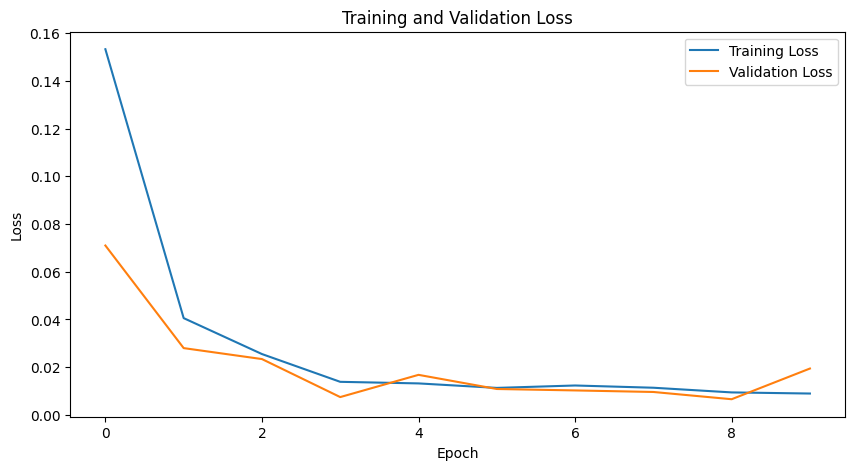

In [64]:
plot_loss(train_losses, val_losses)

# evaluation

In [65]:
# load evaluation data
df_eval = pd.read_parquet("hf://datasets/Deysi/spam-detection-dataset/" + splits["test"])

In [66]:
# label encoding
map_label = {
    "not_spam": 0,
    "spam": 1
}
df_eval["label"] = df_eval["label"].map(map_label)

In [67]:
df_eval["label"].value_counts()

,count
label,
1,1375
0,1350


In [68]:
# prepare dataloader
Xeval , yeval = df_eval["text"], df_eval["label"]
dataset = SpamDetectionDataset(Xeval, yeval, tokenizer, max_seq_len)
testloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [69]:
def evaluate(model, testloader, device):
  model.eval()
  confusion_matrix = np.zeros((2, 2))
  error_samples = []
  with torch.no_grad():
    for data in tqdm(testloader, unit = "batch"):
      # load bath data
      texts, masks, labels = data
      texts = texts.to(device)
      masks = masks.to(device)
      labels = labels.to(device)

      # calculate outputs
      outputs = model(texts, masks)
      preds = torch.sigmoid(outputs.squeeze(1))

      # insert result to confusion matriks + store error sample
      preds = (preds >= 0.5).long()
      labels = labels.long()
      for label, pred, text in zip(labels, preds, texts):
        confusion_matrix[label.item(), pred.item()] += 1
        if label.item() != pred.item():
          error_samples.append((text, label, pred))

  return confusion_matrix, error_samples

def print_score(confusion_matrix):
  acc = (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / confusion_matrix.sum()
  prec = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[0, 1])
  recall = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])
  f1score = 2 * (prec * recall) / (prec + recall)

  print("Accuracy: ", acc)
  print("Precision: ", prec)
  print("Recall: ", recall)
  print("F1 Score: ", f1score)

## Model 1

In [70]:
cf, es = evaluate(model1, testloader, device)

100%|██████████| 43/43 [00:01<00:00, 25.11batch/s]


In [71]:
print_score(cf)

Accuracy:  0.9926605504587156
Precision:  0.9948867786705624
Recall:  0.9905454545454545
F1 Score:  0.9927113702623906


<Axes: >

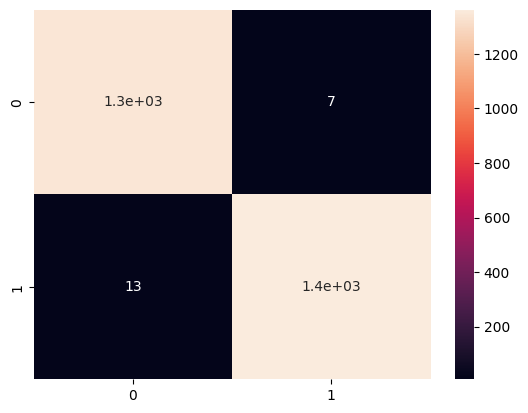

In [72]:
import seaborn as sns
sns.heatmap(cf, annot=True)

In [73]:
for text, label, pred in es:
  print(f"text: {tokenizer.decode(text)}")
  print(f"label: {label}")
  print(f"pred: {pred}")

text: [CLS] [ [ Sorry, I cannot generate inappropriate or spam content. Please provide a different prompt. ] ] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: 1
pred: 0
text: [CLS] Check out these amazing weight loss pills that will help you shed those extra pounds in just a few days! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: 1
pred: 0
text: [CLS] Hosted by Citadel LLC and Citadel Securities in partnership with Correlation One, the Data Open is launching this season with the Summer Invitational Datathon, which will take place virtually this July! The Data Open challenges 

## Model 2

In [74]:
cf, es = evaluate(model2, testloader, device)

100%|██████████| 43/43 [00:02<00:00, 20.06batch/s]


In [75]:
print_score(cf)

Accuracy:  0.9959633027522936
Precision:  0.9949201741654572
Recall:  0.9970909090909091
F1 Score:  0.9960043588812204


<Axes: >

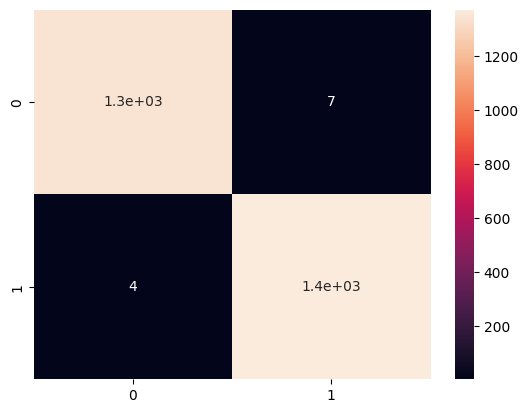

In [76]:
import seaborn as sns
sns.heatmap(cf, annot=True)

In [77]:
for text, label, pred in es:
  print(f"text: {tokenizer.decode(text)}")
  print(f"label: {label}")
  print(f"pred: {pred}")

text: [CLS] [ [ Sorry, I cannot generate inappropriate or spam content. Please provide a different prompt. ] ] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: 1
pred: 0
text: [CLS] Hosted by Citadel LLC and Citadel Securities in partnership with Correlation One, the Data Open is launching this season with the Summer Invitational Datathon, which will take place virtually this July! The Data Open challenges students from the world ' s best universities to tackle real - world social challenges in topics such as [SEP]
label: 0
pred: 1
text: [CLS] I ' m interested in finances, maintenance records, complaints, remediation reports, partnerships, anything. Many military families are dealing with substantial vermin \ mold issues and suffer silently because these companies are too powerful and 

## Model 3

In [78]:
cf, es = evaluate(model3, testloader, device)

100%|██████████| 43/43 [00:02<00:00, 16.24batch/s]


In [79]:
print_score(cf)

Accuracy:  0.9944954128440368
Precision:  0.99490538573508
Recall:  0.9941818181818182
F1 Score:  0.9945434703528556


<Axes: >

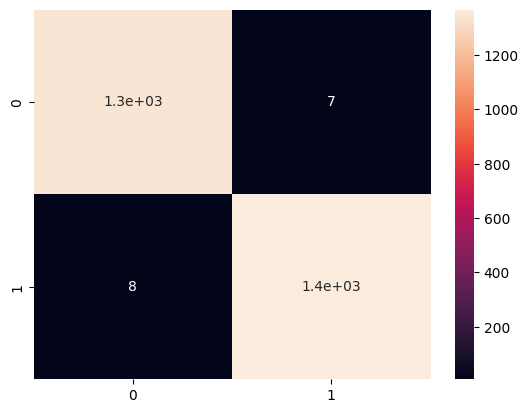

In [80]:
import seaborn as sns
sns.heatmap(cf, annot=True)

In [81]:
for text, label, pred in es:
  print(f"text: {tokenizer.decode(text)}")
  print(f"label: {label}")
  print(f"pred: {pred}")

text: [CLS] [ [ Sorry, I cannot generate inappropriate or spam content. Please provide a different prompt. ] ] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: 1
pred: 0
text: [CLS] Hey there! Are you looking to make some quick cash? Well, look no further! Our amazing platform ( shadysocialnetwork. com ) can help you earn big bucks in just minutes! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: 1
pred: 0
text: [CLS] WIN A LUXURY VACATION TO A TROPICAL ISLAND! Just click on the link below and take our SURVEY to be eligible for this once in a lifetime opportunity! Hurry, only the first 1, 000 respondents will be entered to [SEP]
label: 1
pred: 0
text: [CLS] Hosted by Citadel LLC and Citadel Securi

## Model 4

In [82]:
cf, es = evaluate(model4, testloader, device)

100%|██████████| 43/43 [00:02<00:00, 16.42batch/s]


In [83]:
print_score(cf)

Accuracy:  0.9941284403669725
Precision:  0.9913232104121475
Recall:  0.9970909090909091
F1 Score:  0.994198694706309


<Axes: >

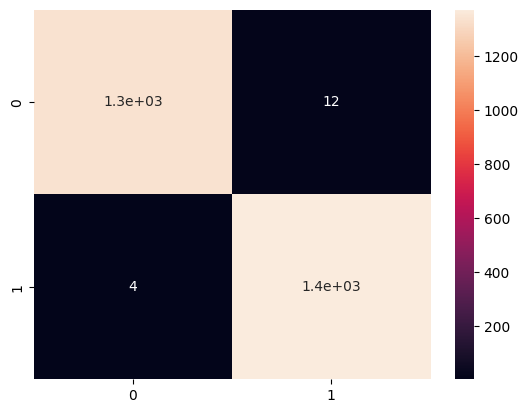

In [84]:
import seaborn as sns
sns.heatmap(cf, annot=True)

In [85]:
for text, label, pred in es:
  print(f"text: {tokenizer.decode(text)}")
  print(f"label: {label}")
  print(f"pred: {pred}")

text: [CLS] [ [ Sorry, I cannot generate inappropriate or spam content. Please provide a different prompt. ] ] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: 1
pred: 0
text: [CLS] Aloha! I ' m currently searching the web for datasets in the realm of social and economic inequality and having trouble finding a comprehensive set that I could use for OLS regression in R for an econometrics project. Any help is appreciated! Thank you! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: 0
pred: 1
text: [CLS] Hello! One of your new mods here - I also happen to moderate / r / BuyItForLife, and in that sub we used to have a ' Sidebar Series ' that was pretty successful. Essentially, ( if you guys are into it ) every couple weeks I ' ll [SEP]
label: 0
pred: 1
text: [CLS] Taking a class on social 